In [1]:
import tensorflow as tf
import numpy as np
from censai import RIMSharedUnet
from censai.models import SharedUnetModel, RayTracer, VAE, VAESecondStage
from censai.utils import nullwriter, rim_residual_plot as residual_plot, plot_to_image
import os, time, json
from datetime import datetime


RIM_HPARAMS = [
    "adam",
    "steps",
    "kappalog",
    "kappa_normalize",
    "kappa_init",
    "source_init"
]
UNET_MODEL_HPARAMS = [
    "filters",
    "filter_scaling",
    "kernel_size",
    "layers",
    "block_conv_layers",
    "strides",
    "bottleneck_kernel_size",
    "bottleneck_filters",
    "resampling_kernel_size",
    "gru_kernel_size",
    "upsampling_interpolation",
    "kernel_regularizer_amp",
    "bias_regularizer_amp",
    "activation",
    "alpha",
    "initializer",
    "kappa_resize_filters",
    "kappa_resize_method",
    "kappa_resize_conv_layers",
    "kappa_resize_strides",
    "kappa_resize_kernel_size",
    "kappa_resize_separate_grad_downsampling"
]

VAE_HPARAMS = [
    "pixels",
    "layers",
    "conv_layers",
    "filter_scaling",
    "filters",
    "kernel_size",
    "kernel_reg_amp",
    "bias_reg_amp",
    "activation",
    "dropout_rate",
    "batch_norm",
    "latent_size"
]

VAE2_HPARAMS = [
    "hidden_layers",
    "kernel_reg_amp",
    "bias_reg_amp",
    "activation",
    "latent_size",
    "units",
    "output_size"
]

In [2]:
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa
from censai.definitions import DTYPE


class PhysicalModel:
    """
    Physical model to be passed to RIM class at instantiation
    """
    def __init__(
            self,
            pixels,            # 512
            psf_sigma=0.06,    # gaussian PSF
            src_pixels=None,   # 128 for cosmos
            kappa_pixels=None,
            image_fov=7.68,
            src_fov=3.0,
            kappa_fov=7.68,
            method="conv2d",
            noise_rms=1,
            raytracer=None
    ):
        if src_pixels is None:
            src_pixels = pixels  # assume src has the same shape
        if kappa_pixels is None:
            kappa_pixels = pixels
        self.image_fov = image_fov
        self.psf_sigma = psf_sigma
        self.src_fov = src_fov
        self.pixels = pixels
        self.src_pixels = src_pixels
        self.kappa_pixels = kappa_pixels
        self.kappa_fov = kappa_fov
        self.method = method
        self.noise_rms = noise_rms
        self.raytracer = raytracer
        self.set_deflection_angle_vars()
        self.PSF = self.psf_model()
        if kappa_pixels != pixels:
            self.kappa_to_image_grid = self._kappa_to_image_grid
        else:
            self.kappa_to_image_grid = tf.identity

    def deflection_angle(self, kappa):
        kappa = self.kappa_to_image_grid(kappa)  # resampling to shape of image
        if self.method == "conv2d":
            alpha_x = tf.nn.conv2d(kappa, self.xconv_kernel, [1, 1, 1, 1], "SAME") * (self.dx_kap**2/np.pi)
            alpha_y = tf.nn.conv2d(kappa, self.yconv_kernel, [1, 1, 1, 1], "SAME") * (self.dx_kap**2/np.pi)

        elif self.method == "unet":
            alpha = self.raytracer(kappa)
            alpha_x, alpha_y = tf.split(alpha, 2, axis=-1)

        elif self.method == "fft":
            """
            The convolution using the Convolution Theorem.
            Since we use FFT to justify this approach, we must zero pad the kernel and kappa map to transform 
            a 'circular convolution' (assumed by our use of FFT) into an an 'acyclic convolution' 
            (sum from m=0 to infinity).
            
            To do that, we pad our signal with N-1 trailing zeros for each dimension. N = 2*pixels+1 since 
            our kernel has this shape.
            
            This approach has complexity O((4*pixels)^2 * log^2(4 * pixels)), and is precise to about rms=2e-5 of the 
            true convolution for the deflection angles.
            """
            # pad the kernel and compute itf fourier transform
            xconv_kernel = tf.image.pad_to_bounding_box(self.xconv_kernel[..., 0], 0, 0, 4*self.pixels+1, 4*self.pixels+1)
            yconv_kernel = tf.image.pad_to_bounding_box(self.yconv_kernel[..., 0], 0, 0, 4*self.pixels+1, 4*self.pixels+1)
            x_kernel_tilde = tf.signal.fft2d(tf.cast(-xconv_kernel[..., 0], tf.complex64))
            y_kernel_tilde = tf.signal.fft2d(tf.cast(-yconv_kernel[..., 0], tf.complex64))

            batch_size = kappa.shape[0]
            alpha_x = []
            alpha_y = []
            for i in range(batch_size):
                kap = tf.image.pad_to_bounding_box(kappa[i, ...],  # pad kappa one by one to save memory space
                                                   offset_height=0,
                                                   offset_width=0,
                                                   target_width=4 * self.pixels + 1,
                                                   target_height=4 * self.pixels + 1)
                kappa_tilde = tf.signal.fft2d(tf.cast(kap[..., 0], tf.complex64))
                alpha_x.append(tf.math.real(tf.signal.ifft2d(kappa_tilde * x_kernel_tilde)) * (self.dx_kap**2/np.pi))
                alpha_y.append(tf.math.real(tf.signal.ifft2d(kappa_tilde * y_kernel_tilde)) * (self.dx_kap**2/np.pi))
            alpha_x = tf.stack(alpha_x, axis=0)[..., tf.newaxis]
            alpha_x = tf.image.crop_to_bounding_box(alpha_x,
                                                    offset_height=self.pixels,
                                                    offset_width=self.pixels,
                                                    target_width=self.pixels,
                                                    target_height=self.pixels)
            alpha_y = tf.stack(alpha_y, axis=0)[..., tf.newaxis]
            alpha_y = tf.image.crop_to_bounding_box(alpha_y,
                                                    offset_height=self.pixels,
                                                    offset_width=self.pixels,
                                                    target_width=self.pixels,
                                                    target_height=self.pixels)
        else:
            raise ValueError(f"{self.method} is not in [conv2d, unet, fft]")
        return alpha_x, alpha_y

    def log_likelihood(self, source, kappa, y_true):
        y_pred = self.forward(source, kappa)
#         lam = tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3)) / tf.reduce_sum(y_pred**2, axis=(1, 2, 3))[..., tf.newaxis, tf.newaxis, tf.newaxis]
        return 0.5 * tf.reduce_mean((y_pred - y_true)**2/self.noise_rms**2, axis=(1, 2, 3))

    def forward(self, source, kappa):
        im = self.lens_source(source, kappa)
        im = self.convolve_with_psf(im)
        return im

    def noisy_forward(self, source, kappa, noise_rms):
        im = self.lens_source(source, kappa)
        noise = tf.random.normal(im.shape, mean=0, stddev=noise_rms)
        out = self.convolve_with_psf(im)  # convolve before adding noise, otherwise it correlates the noise
        out = out + noise
        return out

    def lens_source(self, source, kappa):
        alpha_x, alpha_y = self.deflection_angle(kappa)
        x_src = self.ximage - alpha_x
        y_src = self.yimage - alpha_y
        x_src_pix, y_src_pix = self.src_coord_to_pix(x_src, y_src)
        warp = tf.concat([x_src_pix, y_src_pix], axis=-1)
        im = tfa.image.resampler(source, warp)  # bilinear interpolation of source on warp grid
        return im

    def lens_source_func(self, kappa, xs=0., ys=0., es=0., w=0.1):
        alpha_x, alpha_y = self.deflection_angle(kappa)
        # lens equation
        beta1 = self.ximage - alpha_x
        beta2 = self.yimage - alpha_y
        # sample intensity directly from the functional form
        rho_sq = (beta1 - xs) ** 2 / (1 - es) + (beta2 - ys) ** 2 * (1 - es)
        lens = tf.math.exp(-0.5 * rho_sq / w ** 2)  # / 2 / np.pi / w**2
        lens = self.convolve_with_psf(lens)
        return lens

    def lens_source_func_given_alpha(self, alpha, xs=0., ys=0., es=0., w=0.1):
        alpha1, alpha2 = tf.split(alpha, 2, axis=-1)
        # lens equation
        beta1 = self.ximage - alpha1
        beta2 = self.yimage - alpha2
        # sample intensity directly from the functional form
        rho_sq = (beta1 - xs) ** 2 / (1 - es) + (beta2 - ys) ** 2 * (1 - es)
        lens = tf.math.exp(-0.5 * rho_sq / w ** 2)  # / 2 / np.pi / w**2
        lens = self.convolve_with_psf(lens)
        return lens

    def src_coord_to_pix(self, x, y):
        dx = self.src_fov / (self.src_pixels - 1)
        xmin = -0.5 * self.src_fov
        ymin = -0.5 * self.src_fov
        i_coord = (x - xmin) / dx
        j_coord = (y - ymin) / dx
        return i_coord, j_coord

    def kap_coord_to_pix(self, x, y):
        dx = self.kappa_fov / (self.kappa_pixels - 1)
        xmin = -0.5 * self.kappa_fov
        ymin = -0.5 * self.kappa_fov
        i_coord = (x - xmin) / dx
        j_coord = (y - ymin) / dx
        return i_coord, j_coord

    def _kappa_to_image_grid(self, kappa):
        batch_size = kappa.shape[0]
        x_coord, y_coord = self.kap_coord_to_pix(self.xkappa, self.ykappa)
        warp = tf.concat([x_coord, y_coord], axis=-1)
        warp = tf.tile(warp, [batch_size, 1, 1, 1])  # make sure warp has same batch size has kappa
        kappa = tfa.image.resampler(kappa, warp)
        return kappa

    def set_deflection_angle_vars(self):
        self.dx_kap = self.kappa_fov / (self.pixels - 1)  # dx on image grid

        # Convolution kernel
        x = tf.linspace(-1, 1, 2 * self.pixels + 1) * self.kappa_fov
        xx, yy = tf.meshgrid(x, x)
        rho = xx**2 + yy**2
        xconv_kernel = -self._safe_divide(xx, rho)
        yconv_kernel = -self._safe_divide(yy, rho)
        # reshape to [filter_height, filter_width, in_channels, out_channels]
        self.xconv_kernel = tf.cast(xconv_kernel[..., tf.newaxis, tf.newaxis], dtype=DTYPE)
        self.yconv_kernel = tf.cast(yconv_kernel[..., tf.newaxis, tf.newaxis], dtype=DTYPE)

        # coordinates for image
        x = tf.linspace(-1, 1, self.pixels) * self.image_fov / 2
        xx, yy = tf.meshgrid(x, x)
        # reshape for broadcast to [batch_size, pixels, pixels, 1]
        self.ximage = tf.cast(xx[tf.newaxis, ..., tf.newaxis], dtype=DTYPE)
        self.yimage = tf.cast(yy[tf.newaxis, ..., tf.newaxis], dtype=DTYPE)

        # Coordinates for kappa
        xkappa = tf.cast(tf.linspace(-1, 1, self.pixels), dtype=DTYPE) * self.kappa_fov / 2
        xkappa, ykappa = tf.meshgrid(xkappa, xkappa)
        self.xkappa = tf.cast(xkappa[tf.newaxis, ..., tf.newaxis], dtype=DTYPE)
        self.ykappa = tf.cast(ykappa[tf.newaxis, ..., tf.newaxis], dtype=DTYPE)


    @staticmethod
    def _safe_divide(num, denominator):
        out = np.zeros_like(num)
        out[denominator != 0] = num[denominator != 0] / denominator[denominator != 0]
        return out

    def psf_model(self):
        pixel_scale = self.image_fov / self.pixels
        cutout_size = int(10 * self.psf_sigma / pixel_scale)
        r_squared = self.ximage**2 + self.yimage**2
        psf = tf.math.exp(-0.5 * r_squared / self.psf_sigma**2)
        psf = tf.image.crop_to_bounding_box(psf,
                                            offset_height=self.pixels//2 - cutout_size//2,
                                            offset_width=self.pixels//2 - cutout_size//2,
                                            target_width=cutout_size,
                                            target_height=cutout_size)
        psf /= tf.reduce_sum(psf)
        psf = tf.reshape(psf, shape=[cutout_size, cutout_size, 1, 1])
        return psf

    def convolve_with_psf(self, images):
        convolved_images = tf.nn.conv2d(images, self.PSF, [1, 1, 1, 1], padding="SAME")
        return convolved_images


In [3]:
def main(args):
    if args.raytracer is not None:
        with open(os.path.join(args.raytracer, "ray_tracer_hparams.json"), "r") as f:
            raytracer_hparams = json.load(f)
    if args.raytracer is not None:
        raytracer = RayTracer(**raytracer_hparams)
        # load last checkpoint in the checkpoint directory
        checkpoint = tf.train.Checkpoint(net=raytracer)
        manager = tf.train.CheckpointManager(checkpoint, directory=args.raytracer, max_to_keep=3)
        checkpoint.restore(manager.latest_checkpoint).expect_partial()
    else:
        raytracer = None
    
    # =============== kappa vae ========================================
    # Load first stage and freeze weights
    with open(os.path.join(args.kappa_first_stage_vae, "model_hparams.json"), "r") as f:
        kappa_vae_hparams = json.load(f)
    kappa_vae = VAE(**kappa_vae_hparams)
    ckpt1 = tf.train.Checkpoint(step=tf.Variable(1), net=kappa_vae)
    checkpoint_manager1 = tf.train.CheckpointManager(ckpt1, args.kappa_first_stage_vae, 1)
    checkpoint_manager1.checkpoint.restore(checkpoint_manager1.latest_checkpoint).expect_partial()
    kappa_vae.trainable = False
    kappa_vae.encoder.trainable = False
    kappa_vae.decoder.trainable = False
    
    # Setup sampling from second stage if provided
    if args.kappa_second_stage_vae is not None:
        with open(os.path.join(args.kappa_second_stage_vae, "model_hparams.json"), "r") as f:
            kappa_vae2_hparams = json.load(f)
        kappa_vae2 = VAESecondStage(**kappa_vae2_hparams)
        ckpt1 = tf.train.Checkpoint(step=tf.Variable(1), net=kappa_vae2)
        checkpoint_manager1 = tf.train.CheckpointManager(ckpt1, args.kappa_second_stage_vae, 1)
        checkpoint_manager1.checkpoint.restore(checkpoint_manager1.latest_checkpoint).expect_partial()
        kappa_vae2.trainable = False
        kappa_vae2.encoder.trainable = False
        kappa_vae2.decoder.trainable = False
        kappa_sampling_function = lambda batch_size: 10**kappa_vae.decode(kappa_vae2.sample(batch_size))
    else:
        kappa_sampling_function = lambda batch_size: 10**kappa_vae.sample(batch_size)

    # =============== source vae ========================================
    # Load first stage and freeze weights
    with open(os.path.join(args.source_first_stage_vae, "model_hparams.json"), "r") as f:
        source_vae_hparams = json.load(f)
    source_vae = VAE(**source_vae_hparams)
    ckpt1 = tf.train.Checkpoint(step=tf.Variable(1), net=source_vae)
    checkpoint_manager1 = tf.train.CheckpointManager(ckpt1, args.source_first_stage_vae, 1)
    checkpoint_manager1.checkpoint.restore(checkpoint_manager1.latest_checkpoint).expect_partial()
    source_vae.trainable = False
    source_vae.encoder.trainable = False
    source_vae.decoder.trainable = False

    # Setup sampling from second stage if provided
    if args.source_second_stage_vae is not None:
        with open(os.path.join(args.source_second_stage_vae, "model_hparams.json"), "r") as f:
            source_vae2_hparams = json.load(f)
        source_vae2 = VAESecondStage(**source_vae2_hparams)
        ckpt1 = tf.train.Checkpoint(step=tf.Variable(1), net=source_vae2)
        checkpoint_manager1 = tf.train.CheckpointManager(ckpt1, args.source_second_stage_vae, 1)
        checkpoint_manager1.checkpoint.restore(checkpoint_manager1.latest_checkpoint).expect_partial()
        source_vae2.trainable = False
        source_vae2.encoder.trainable = False
        source_vae2.decoder.trainable = False
        source_sampling_function = lambda batch_size: source_vae.decode(source_vae2.sample(batch_size))
    else:
        source_sampling_function = lambda batch_size: source_vae.sample(batch_size)

    phys = PhysicalModel(
        pixels=args.image_pixels,
        kappa_pixels=kappa_vae_hparams["pixels"],
        src_pixels=source_vae_hparams["pixels"],
        image_fov=args.image_fov,
        kappa_fov=args.kappa_fov,
        src_fov=args.source_fov,
        method=args.forward_method,
        noise_rms=args.noise_rms,
        raytracer=raytracer,
        psf_sigma=args.psf_sigma
    )

    unet = SharedUnetModel(
        filters=args.filters,
        filter_scaling=args.filter_scaling,
        kernel_size=args.kernel_size,
        layers=args.layers,
        block_conv_layers=args.block_conv_layers,
        strides=args.strides,
        bottleneck_kernel_size=args.bottleneck_kernel_size,
        bottleneck_filters=args.bottleneck_filters,
        resampling_kernel_size=args.resampling_kernel_size,
        gru_kernel_size=args.gru_kernel_size,
        upsampling_interpolation=args.upsampling_interpolation,
        kernel_regularizer_amp=args.kernel_regularizer_amp,
        bias_regularizer_amp=args.bias_regularizer_amp,
        activation=args.activation,
        alpha=args.alpha,
        initializer=args.initializer,
    )
    rim = RIMSharedUnet(
        physical_model=phys,
        unet=unet,
        steps=args.steps,
        adam=args.adam,
        kappalog=args.kappalog,
        source_link=args.source_link,
        kappa_normalize=args.kappa_normalize,
        kappa_init=args.kappa_init,
        source_init=args.source_init
    )
    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=args.initial_learning_rate,
        decay_rate=args.decay_rate,
        decay_steps=args.decay_steps,
        staircase=args.staircase
    )
    optim = tf.keras.optimizers.deserialize(
        {
            "class_name": args.optimizer,
            'config': {"learning_rate": learning_rate_schedule}
        }
    )

    # ==== Take care of where to write logs and stuff =================================================================
    if args.model_id.lower() != "none":
        logname = args.model_id
    elif args.logname is not None:
        logname = args.logname
    else:
        logname = args.logname_prefixe + "_" + datetime.now().strftime("%y-%m-%d_%H-%M-%S")
    if args.logdir.lower() != "none":
        logdir = os.path.join(args.logdir, logname)
        if not os.path.isdir(logdir):
            os.mkdir(logdir)
        writer = tf.summary.create_file_writer(logdir)
    else:
        writer = nullwriter()
    # ===== Make sure directory and checkpoint manager are created to save model ===================================
    if args.model_dir.lower() != "none":
        checkpoints_dir = os.path.join(args.model_dir, logname)
        if not os.path.isdir(checkpoints_dir):
            os.mkdir(checkpoints_dir)
            with open(os.path.join(checkpoints_dir, "script_params.json"), "w") as f:
                json.dump(vars(args), f, indent=4)
            with open(os.path.join(checkpoints_dir, "unet_hparams.json"), "w") as f:
                hparams_dict = {key: vars(args)[key] for key in UNET_MODEL_HPARAMS}
                json.dump(hparams_dict, f, indent=4)
            with open(os.path.join(checkpoints_dir, "rim_hparams.json"), "w") as f:
                hparams_dict = {key: vars(args)[key] for key in RIM_HPARAMS}
                json.dump(hparams_dict, f, indent=4)
        ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optim, net=rim.unet)
        checkpoint_manager = tf.train.CheckpointManager(ckpt, checkpoints_dir, max_to_keep=args.max_to_keep)
        save_checkpoint = True
        # ======= Load model if model_id is provided ===============================================================
        if args.model_id.lower() != "none":
            if args.load_checkpoint == "lastest":
                checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint)
            elif args.load_checkpoint == "best":
                scores = np.loadtxt(os.path.join(checkpoints_dir, "score_sheet.txt"))
                _checkpoint = scores[np.argmin(scores[:, 1]), 0]
                checkpoint = checkpoint_manager.checkpoints[_checkpoint]
                checkpoint_manager.checkpoint.restore(checkpoint)
            else:
                checkpoint = checkpoint_manager.checkpoints[int(args.load_checkpoint)]
                checkpoint_manager.checkpoint.restore(checkpoint)
    else:
        save_checkpoint = False
    # =================================================================================================================

    def train_step(X, source, kappa):
        with tf.GradientTape() as tape:
            tape.watch(rim.unet.trainable_variables)
            source_series, kappa_series, chi_squared = rim.call(X, outer_tape=tape)
            source_cost = tf.reduce_mean(tf.square(source_series - rim.source_inverse_link(source)), axis=(0, 2, 3, 4))
            kappa_cost = tf.reduce_mean(tf.square(kappa_series - rim.kappa_inverse_link(kappa)), axis=(0, 2, 3, 4))
            cost = tf.reduce_sum(kappa_cost + source_cost) / args.batch_size
        gradient = tape.gradient(cost, rim.unet.trainable_variables)
        if args.clipping:
            gradient = [tf.clip_by_value(grad, -10, 10) for grad in gradient]
        optim.apply_gradients(zip(gradient, rim.unet.trainable_variables))
        chi_squared = tf.reduce_sum(chi_squared) / args.batch_size
        source_cost = tf.reduce_sum(source_cost) / args.batch_size
        kappa_cost = tf.reduce_sum(kappa_cost) / args.batch_size
        return cost, chi_squared, source_cost, kappa_cost

    # ====== Training loop ============================================================================================
    epoch_loss = tf.metrics.Mean()
    time_per_step = tf.metrics.Mean()
    epoch_chi_squared = tf.metrics.Mean()
    epoch_source_cost = tf.metrics.Mean()
    epoch_kappa_cost = tf.metrics.Mean()
    history = {  # recorded at the end of an epoch only
        "cost": [],
        "chi_squared": [],
        "source_cost": [],
        "kappa_cost": [],
        "learning_rate": [],
        "time_per_step": [],
        "step": []
    }
    best_loss = np.inf
    patience = args.patience
    step = 0
    global_start = time.time()
    estimated_time_for_epoch = 0
    out_of_time = False
    lastest_checkpoint = 1
    for epoch in range(args.epochs):
        if (time.time() - global_start) > args.max_time*3600 - estimated_time_for_epoch:
            break
        epoch_start = time.time()
        epoch_loss.reset_states()
        epoch_chi_squared.reset_states()
        epoch_source_cost.reset_states()
        epoch_kappa_cost.reset_states()
        time_per_step.reset_states()
        with writer.as_default():
            for batch in range(args.total_items // args.batch_size):
                start = time.time()
                kappa = kappa_sampling_function(args.batch_size)
                source = source_sampling_function(args.batch_size)
                source /= tf.reduce_max(source, axis=(1, 2, 3), keepdims=True)
                X = tf.nn.relu(phys.noisy_forward(source, kappa, noise_rms=args.noise_rms))
                cost, chi_squared, source_cost, kappa_cost = train_step(X, source, kappa)

        # ========== Summary and logs ==================================================================================
                _time = time.time() - start
                tf.summary.scalar("Time per step", _time, step=step)
                tf.summary.scalar("MSE", cost, step=step)
                tf.summary.scalar("Chi Squared", chi_squared, step=step)
                tf.summary.scalar("Source Cost", source_cost, step=step)
                tf.summary.scalar("Kappa Cost", kappa_cost, step=step)
                time_per_step.update_state([_time])
                epoch_loss.update_state([cost])
                epoch_chi_squared.update_state([chi_squared])
                epoch_source_cost.update_state([source_cost])
                epoch_kappa_cost.update_state([kappa_cost])
                step += 1
            if args.n_residuals > 0:
                kappa_true = kappa_sampling_function(args.n_residuals)
                source_true = source_sampling_function(args.n_residuals)
                source_true /= tf.reduce_max(source_true, axis=(1, 2, 3), keepdims=True)
                lens_true = tf.nn.relu(phys.noisy_forward(source_true, kappa_true, noise_rms=args.noise_rms))
                source_pred, kappa_pred, chi_squared = rim.predict(lens_true)
                lens_pred = phys.forward(source_pred[-1], kappa_pred[-1])
            for res_idx in range(args.n_residuals):
                try:
                    tf.summary.image(f"Residuals {res_idx}",
                                     plot_to_image(
                                         residual_plot(
                                             lens_true[res_idx],
                                             source_true[res_idx, ...],
                                             kappa_true[res_idx, ...],
                                             lens_pred[res_idx],
                                             source_pred[-1][res_idx, ...],
                                             kappa_pred[-1][res_idx, ...],
                                             chi_squared[-1][res_idx]
                                         )), step=step)
                except ValueError:
                    continue

            train_cost = epoch_loss.result().numpy()
            train_chi_sq = epoch_chi_squared.result().numpy()
            train_s_cost = epoch_source_cost.result().numpy()
            train_k_cost = epoch_kappa_cost.result().numpy()
            tf.summary.scalar("Learning Rate", optim.lr(step), step=step)
        print(f"step {step} | train loss {train_cost:.3e} | chi sq {train_chi_sq:.3e}"
              f"| learning rate {optim.lr(step).numpy():.2e} | time per step {time_per_step.result().numpy():.2e} s")
        history["cost"].append(train_cost)
        history["learning_rate"].append(optim.lr(step).numpy())
        history["chi_squared"].append(train_chi_sq)
        history["time_per_step"].append(time_per_step.result().numpy())
        history["kappa_cost"].append(train_k_cost)
        history["source_cost"].append(train_s_cost)
        history["step"].append(step)

        cost = train_cost
        if np.isnan(cost):
            print("Training broke the Universe")
            break
        if cost < (1 - args.tolerance) * best_loss:
            best_loss = cost
            patience = args.patience
        else:
            patience -= 1
        if (time.time() - global_start) > args.max_time * 3600:
            out_of_time = True
        if save_checkpoint:
            checkpoint_manager.checkpoint.step.assign_add(1) # a bit of a hack
            if epoch % args.checkpoints == 0 or patience == 0 or epoch == args.epochs - 1 or out_of_time:
                with open(os.path.join(checkpoints_dir, "score_sheet.txt"), mode="a") as f:
                    np.savetxt(f, np.array([[lastest_checkpoint, cost]]))
                lastest_checkpoint += 1
                checkpoint_manager.save()
                print("Saved checkpoint for step {}: {}".format(int(checkpoint_manager.checkpoint.step), checkpoint_manager.latest_checkpoint))
        if patience == 0:
            print("Reached patience")
            break
        if out_of_time:
            break
        if epoch > 0:  # First epoch is always very slow and not a good estimate of an epoch time.
            estimated_time_for_epoch = time.time() - epoch_start
    print(f"Finished training after {(time.time() - global_start)/3600:.3f} hours.")
    return history, rim, phys, kappa_sampling_function, source_sampling_function

In [4]:
from argparse import ArgumentParser
parser = ArgumentParser()
parser.add_argument("--model_id",                   default="None",                 help="Start from this model id checkpoint. None means start from scratch")
parser.add_argument("--load_checkpoint",            default="best",                 help="One of 'best', 'lastest' or the specific checkpoint index.")
parser.add_argument("--kappa_first_stage_vae",      required=True)
parser.add_argument("--kappa_second_stage_vae",     default=None)
parser.add_argument("--source_first_stage_vae",     required=True)
parser.add_argument("--source_second_stage_vae",    default=None)

# RIM hyperparameters
parser.add_argument("--steps",              default=16,     type=int,       help="Number of time steps of RIM")
parser.add_argument("--adam",               action="store_true",            help="ADAM update for the log-likelihood gradient.")
parser.add_argument("--kappalog",           action="store_true")
parser.add_argument("--kappa_normalize",    action="store_true")
parser.add_argument("--source_link",        default="identity",             help="One of 'exp', 'source', 'relu' or 'identity' (default).")
parser.add_argument("--kappa_init",         default=1e-1,   type=float,     help="Initial value of kappa for RIM")
parser.add_argument("--source_init",        default=1e-3,   type=float,     help="Initial value of source for RIM")

# Shared Unet params
parser.add_argument("--filters",                                    default=32,     type=int)
parser.add_argument("--filter_scaling",                             default=1,      type=float)
parser.add_argument("--kernel_size",                                default=3,      type=int)
parser.add_argument("--layers",                                     default=2,      type=int)
parser.add_argument("--block_conv_layers",                          default=2,      type=int)
parser.add_argument("--strides",                                    default=2,      type=int)
parser.add_argument("--bottleneck_kernel_size",                     default=None,   type=int)
parser.add_argument("--bottleneck_filters",                         default=None,   type=int)
parser.add_argument("--resampling_kernel_size",                     default=None,   type=int)
parser.add_argument("--gru_kernel_size",                            default=None,   type=int)
parser.add_argument("--upsampling_interpolation",                   action="store_true")
parser.add_argument("--kernel_regularizer_amp",                     default=1e-4,   type=float)
parser.add_argument("--bias_regularizer_amp",                       default=1e-4,   type=float)
parser.add_argument("--activation",                                 default="leaky_relu")
parser.add_argument("--alpha",                                      default=0.1,    type=float)
parser.add_argument("--initializer",                                default="glorot_normal")

# Physical model hyperparameter
parser.add_argument("--forward_method",         default="conv2d",               help="One of ['conv2d', 'fft', 'unet']. If the option 'unet' is chosen, the parameter "
                                                                                     "'--raytracer' must be provided and point to model checkpoint directory.")
parser.add_argument("--raytracer",              default=None,                   help="Path to raytracer checkpoint dir if method 'unet' is used.")
parser.add_argument("--image_pixels",           default=512,    type=int,       help="Number of pixels on a side of the lensed image")
parser.add_argument("--image_fov",              default=20,     type=float,     help="Field of view of lensed image in arcsec")
parser.add_argument("--kappa_fov",              default=18,     type=float,     help="Field of view of kappa map (in lens plane), in arcsec")
parser.add_argument("--source_fov",             default=3,      type=float,     help="Field of view of source map, in arcsec")
parser.add_argument("--noise_rms",              default=1e-2,   type=float,     help="RMS of white noise added to lensed image")
parser.add_argument("--psf_sigma",              default=0.08,   type=float,     help="Size, in arcseconds, of the gaussian blurring PSF")


# Training set params
parser.add_argument("-b", "--batch_size",       default=1,      type=int,       help="Number of images in a batch. ")
parser.add_argument("--total_items",            required=True,  type=int,       help="Total images in an epoch.")

# Optimization params
parser.add_argument("-e", "--epochs",           default=10,     type=int,       help="Number of epochs for training.")
parser.add_argument("--optimizer",              default="Adam",                 help="Class name of the optimizer (e.g. 'Adam' or 'Adamax')")
parser.add_argument("--initial_learning_rate",  default=1e-3,   type=float,     help="Initial learning rate.")
parser.add_argument("--decay_rate",             default=1.,     type=float,     help="Exponential decay rate of learning rate (1=no decay).")
parser.add_argument("--decay_steps",            default=1000,   type=int,       help="Decay steps of exponential decay of the learning rate.")
parser.add_argument("--staircase",              action="store_true",            help="Learning rate schedule only change after decay steps if enabled.")
parser.add_argument("--clipping",               action="store_true",            help="Clip backprop gradients between -10 and 10.")
parser.add_argument("--patience",               default=np.inf, type=int,       help="Number of step at which training is stopped if no improvement is recorder.")
parser.add_argument("--tolerance",              default=0,      type=float,     help="Current score <= (1 - tolerance) * best score => reset patience, else reduce patience.")
parser.add_argument("--max_time",               default=np.inf, type=float,     help="Time allowed for the training, in hours.")

# logs
parser.add_argument("--logdir",                  default="None",                help="Path of logs directory. Default if None, no logs recorded.")
parser.add_argument("--logname",                 default=None,                  help="Overwrite name of the log with this argument")
parser.add_argument("--logname_prefixe",         default="RIMSUwVAE",           help="If name of the log is not provided, this prefix is prepended to the date")
parser.add_argument("--model_dir",               default="None",                help="Path to the directory where to save models checkpoints.")
parser.add_argument("--checkpoints",             default=10,    type=int,       help="Save a checkpoint of the models each {%} iteration.")
parser.add_argument("--max_to_keep",             default=3,     type=int,       help="Max model checkpoint to keep.")
parser.add_argument("--n_residuals",             default=1,     type=int,       help="Number of residual plots to save. Add overhead at the end of an epoch only.")

# Reproducibility params
parser.add_argument("--seed",                   default=None,   type=int,       help="Random seed for numpy and tensorflow.")
parser.add_argument("--json_override",          default=None, nargs="+",        help="A json filepath that will override every command line parameters. Useful for reproducibility")




_StoreAction(option_strings=['--json_override'], dest='json_override', nargs='+', const=None, default=None, type=None, choices=None, help='A json filepath that will override every command line parameters. Useful for reproducibility', metavar=None)

In [13]:
import sys
sys.argv = ['']
args = parser.parse_args(
  f"--kappa_first_stage_vae={os.getenv('CENSAI_PATH')}/models/VAE1_kappa_HPARAMS2_010_CL2_F64_NLbipolar_relu_LS32_210812184741 "\
  f"--kappa_second_stage_vae={os.getenv('CENSAI_PATH')}/models/VAE1_kappa_HPARAMS2_010_CL2_F64_NLbipolar_relu_LS32_210812184741_second_stage_210813104442 "\
  f"--source_first_stage_vae={os.getenv('CENSAI_PATH')}/models/VAE1_cosmos_HPARAMS_029_L3_CL4_F16_NLleaky_relu_LS128_ssi0.001_210810161842 "\
  f"--source_second_stage_vae={os.getenv('CENSAI_PATH')}/models/VAE1_cosmos_HPARAMS_029_L3_CL4_F16_NLleaky_relu_LS128_ssi0.001_210810161842_second_stage_210812235647 "\
  f"--image_pixels=512 "\
  f"--image_fov=20 "\
  f"--kappa_fov=20 "\
  f"--source_fov=3 "\
  f"--noise_rms=1e-2 "\
  f"--psf_sigma=0.08 "\
  f"--forward_method=fft "\
  f"--epochs=10000 "\
  f"--max_time=0.5 "\
  f"--initial_learning_rate=6e-4 "\
  f"--decay_rate=0.8 "\
  f"--decay_steps=500 "\
  f"--staircase "\
  f"--clipping "\
  f"--patience=500 "\
  f"--tolerance=0.0 "\
  f"--batch_size=1 "\
  f"--total_items=1 "\
  f"--steps=4 "\
  f"--adam "\
  f"--kappalog "\
  f"--source_link=lrelu4p "\
  f"--source_init=1e-3 "\
  f"--filters=32 "\
  f"--filter_scaling=2 "\
  f"--kernel_size=3 "\
  f"--layers=4 "\
  f"--block_conv_layers=2 "\
  f"--activation=leaky_relu "\
  f"--resampling_kernel_size=5 "\
  f"--gru_kernel_size=3 "\
  f"--kernel_regularizer_amp=1e-4 "\
  f"--bias_regularizer_amp=1e-4 "\
  f"--upsampling_interpolation "\
  f"--logdir={os.getenv('HOME')}/scratch/Censai/logs "\
  f"--logname_prefixe=RIMSU128_wVAE_I "\
#   f"--model_dir={os.getenv('HOME')}/scratch/Censai/models "\
#   f"--checkpoints=5 "\
#   f"--max_to_keep=10 "\
  f"--n_residuals=0".split()

)
if args.seed is not None:
    tf.random.set_seed(args.seed)
    np.random.seed(args.seed)
history, rim, phys, kappa_sampling_func, source_sampling_func = main(args)

step 1 | train loss 1.090e-01 | chi sq 1.127e+01| learning rate 6.00e-04 | time per step 1.10e+02 s
step 2 | train loss 1.131e-01 | chi sq 2.515e+01| learning rate 6.00e-04 | time per step 5.69e-01 s
step 3 | train loss 1.264e-01 | chi sq 8.835e+00| learning rate 6.00e-04 | time per step 5.61e-01 s
step 4 | train loss 1.595e-01 | chi sq 1.119e+02| learning rate 6.00e-04 | time per step 5.61e-01 s
step 5 | train loss 9.078e-02 | chi sq 2.097e+01| learning rate 6.00e-04 | time per step 5.60e-01 s
step 6 | train loss 8.717e-02 | chi sq 1.520e+01| learning rate 6.00e-04 | time per step 5.62e-01 s
step 7 | train loss 1.013e-01 | chi sq 5.542e+01| learning rate 6.00e-04 | time per step 5.62e-01 s
step 8 | train loss 1.073e-01 | chi sq 1.082e+01| learning rate 6.00e-04 | time per step 5.61e-01 s
step 9 | train loss 1.327e-01 | chi sq 6.951e+00| learning rate 6.00e-04 | time per step 5.62e-01 s
step 10 | train loss 6.910e-02 | chi sq 3.347e+01| learning rate 6.00e-04 | time per step 5.60e-01 s

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-5-5d4006368deb>", line 53, in <module>
    history, rim, phys, kappa_sampling_func, source_sampling_func = main(args)  File "<ipython-input-3-e83e7e7a606c>", line 264, in main
    tf.summary.scalar("Learning Rate", optim.lr(step), step=step)  File "<ipython-input-3-e83e7e7a606c>", line 175, in train_step
    cost = tf.reduce_sum(kappa_cost + source_cost) / args.batch_size  File "/lustre04/scratch/aadam/Censai/censai/rim_shared_unet.py", line 131, in call
    source_grad, kappa_grad = self.grad_update(source_grad, kappa_grad, current_step)  File "/home/aadam/environments/censai3.8/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 247, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
ERROR:

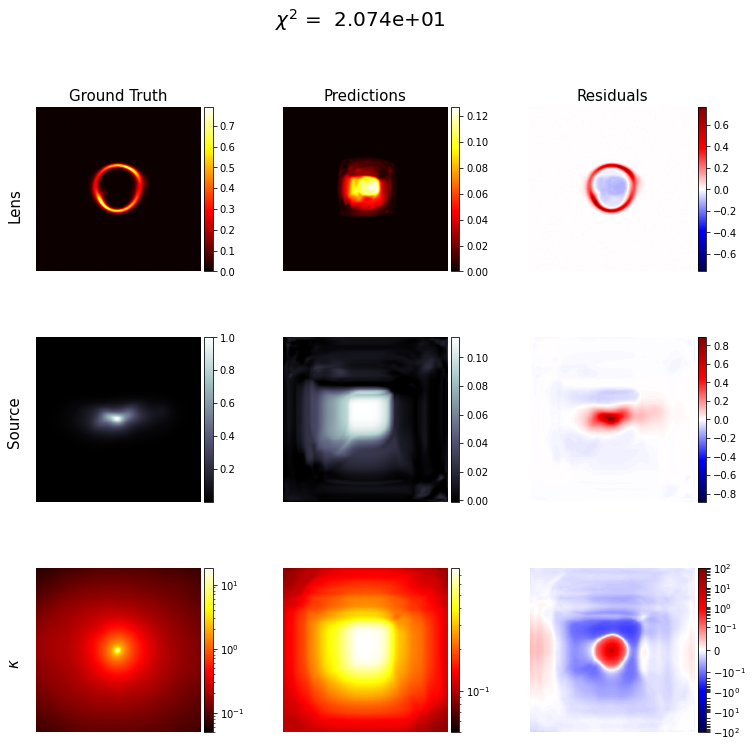

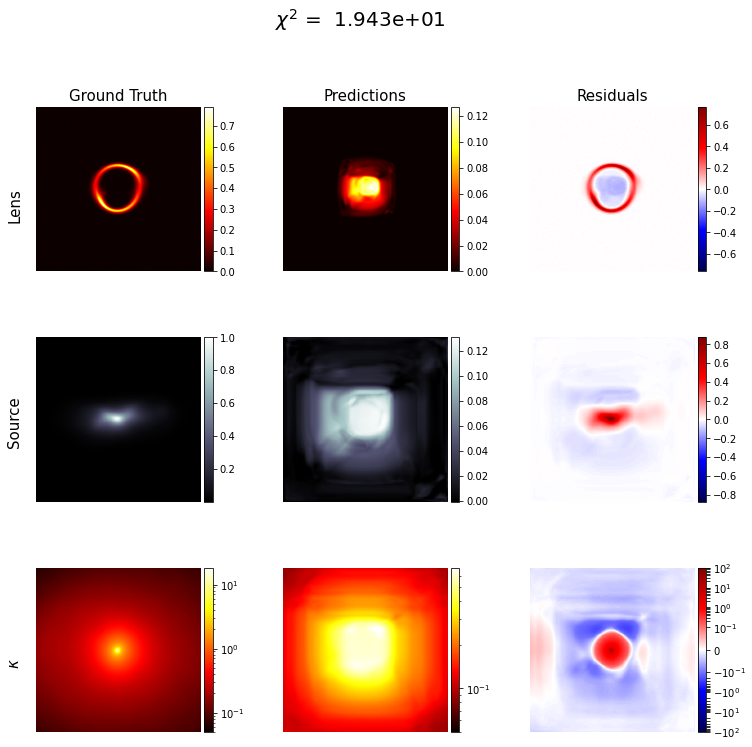

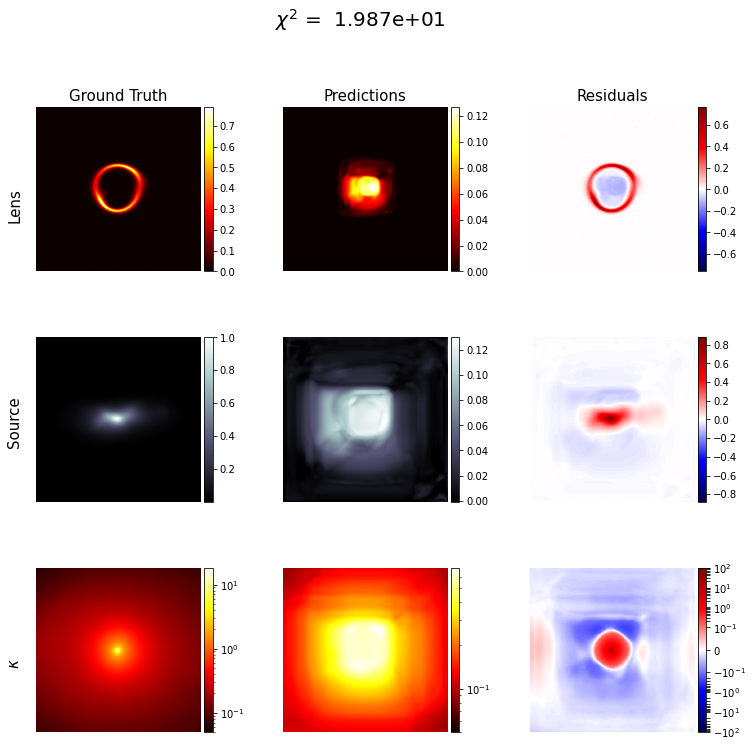

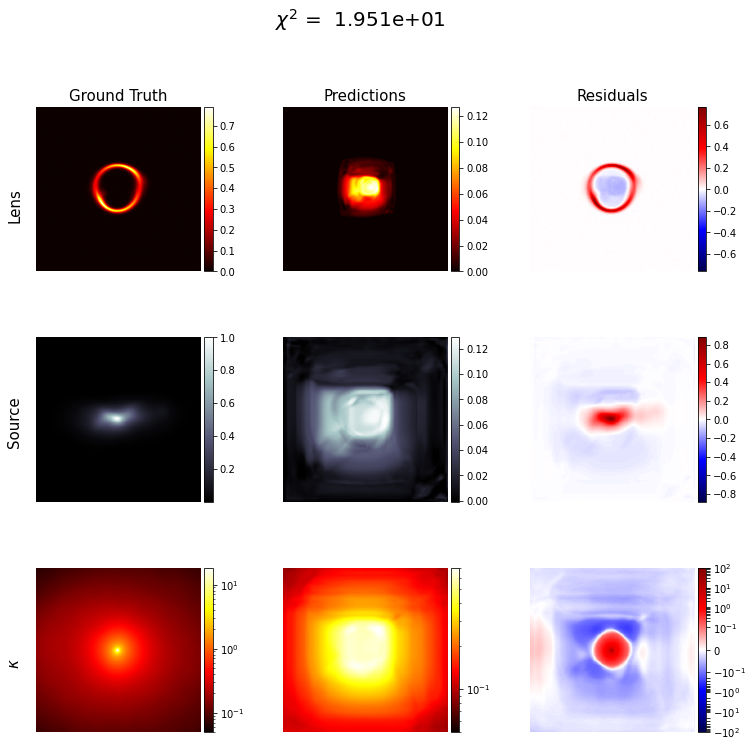

In [29]:
kappa_true = kappa_sampling_func(1)
source_true = source_sampling_func(1)
source_true /= tf.reduce_max(source_true, axis=(1, 2, 3), keepdims=True)
lens_true = tf.nn.relu(phys.noisy_forward(source_true, kappa_true, noise_rms=args.noise_rms))
source_pred, kappa_pred, chi_squared = rim.predict(lens_true)
lens_pred = phys.forward(source_pred[-1], kappa_pred[-1])
for t in range(args.steps):
    residual_plot(
        lens_true[0],
        source_true[0, ...],
        kappa_true[0, ...],
        lens_pred[0],
        source_pred[t][0, ...],
        kappa_pred[t][0, ...],
        chi_squared[t][0]
    )

In [21]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    x = np.atleast_1d(x)
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    # padding
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[(window_len-1)//2:-(window_len)//2] # remove padding



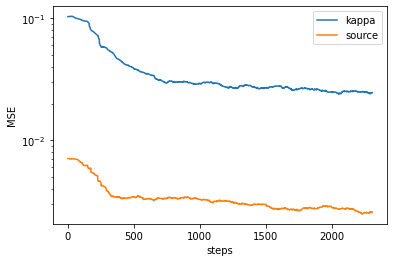

In [28]:
import matplotlib.pyplot as plt
steps = history["step"]
smooth_window_len = 400
smooth_window = 'flat'
plt.plot(steps, smooth(history["kappa_cost"], smooth_window_len, smooth_window), label="kappa")
plt.plot(steps, smooth(history["source_cost"], smooth_window_len, smooth_window), label="source")
# plt.plot(steps, smooth(history["chi_squared"], smooth_window_len, smooth_window), label=r"$\chi^2$")
plt.yscale('log')
plt.ylabel("MSE")
plt.xlabel("steps")
plt.legend()